In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fancyimpute import KNN
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\Kiran\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Kiran\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Set Working Directory
os.chdir("C:/Users/Kiran/Desktop/Project - 1")

In [3]:
#Load Data
Data = pd.read_csv("day.csv")

In [4]:
#Drop First column - instant - does not contribute to data analysis
BikeRent = Data.drop(['instant'],1)

In [5]:
#Exploratory Data Analysis
#Consider following variables and convert them into Categorical
Cat_Var = ['season', 'yr', 'mnth', 'weekday', 'holiday', 'workingday', 'weathersit']

#Loop to convert into Categorical
for i in Cat_Var:
     BikeRent[i] = BikeRent[i].astype('object')
    
#'dteday' is separately treated

In [6]:
#Save the continuous variables in Con_Var
Con_Var = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

In [7]:
#Re-check Data
BikeRent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
dteday        731 non-null object
season        731 non-null object
yr            731 non-null object
mnth          731 non-null object
holiday       731 non-null object
weekday       731 non-null object
workingday    731 non-null object
weathersit    731 non-null object
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(3), object(8)
memory usage: 85.7+ KB


## Missing Value Analysis

In [8]:
#Check for existence of missing values if any
BikeRent.isnull().sum()
#No missing values found

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

# Outlier Analysis

In [9]:
#Make a copy of pre-processed data
BikeRent1 = BikeRent.copy()
#BikeRent = BikeRent1.copy()

In [ ]:
#Finding which variables have outliers
%matplotlib inline
#plt.boxplot(BikeRent['hum'])  #Outeliers
#plt.boxplot(BikeRent['windspeed'])  #Outeliers
plt.boxplot(BikeRent['casual']) #Outeliers



In [ ]:
# #Detect and delete outliers from data
# for i in ('hum', 'windspeed', 'casual'):
#     print(i)

#     q75, q25 = np.percentile(BikeRent.loc[:,i], [75,25])
#     iqr = q75-q25
    
#     min = q25 - (iqr*1.5)
#     max = q75 + (iqr*1.5)
    
#     BikeRent = BikeRent.drop(BikeRent[BikeRent.loc[:,i]<min].index)
#     BikeRent = BikeRent.drop(BikeRent[BikeRent.loc[:,i]>max].index)

In [10]:
#check how many outliers could have been removed from above procedure
BikeRent.shape 

#55 outliers could be removed

(731, 15)

In [11]:
#Replacing outliers by nan
##Imputing by mean and median methods
#Load BikeRent from BikeRent1

for i in ('hum', 'windspeed', 'casual'):
    print(i)
    q75, q25 = np.percentile(BikeRent.loc[:,i], [75,25])
    iqr = q75 - q25
    
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5)
    
    #Impute outliers with nan
    BikeRent.loc[BikeRent[i] < min,i] = np.nan
    BikeRent.loc[BikeRent[i] > max,i] = np.nan 
    
    #Replace nan by mean method
    #BikeRent[i] = BikeRent[i].fillna(BikeRent[i].mean())
    
    #Load BikeRent from BikeRent1 again
    #Replace nan by median method
    #BikeRent[i] = BikeRent[i].fillna(BikeRent[i].median())

hum
windspeed
casual


In [12]:
#Apply KNN Imputation on "hum", "windspeed" & "casual" only

#Save variables with outliers from BikeRent into OutLiers
OutLiers = BikeRent[['hum', 'windspeed', 'casual']]

#Applying KNN imputation method
OutLiers = pd.DataFrame(KNN(k = 1).complete(OutLiers), columns = OutLiers.columns)

#Restore the variables after imputing outliers back into BikeRent
BikeRent[['hum', 'windspeed', 'casual']] = OutLiers

Imputing row 1/731 with 0 missing, elapsed time: 1.309
Imputing row 101/731 with 0 missing, elapsed time: 1.325
Imputing row 201/731 with 0 missing, elapsed time: 1.325
Imputing row 301/731 with 0 missing, elapsed time: 1.325
Imputing row 401/731 with 0 missing, elapsed time: 1.325
Imputing row 501/731 with 0 missing, elapsed time: 1.325
Imputing row 601/731 with 0 missing, elapsed time: 1.340
Imputing row 701/731 with 0 missing, elapsed time: 1.340


# Feature Selection

In [13]:
#Feature Engineering - 1: extract 'day' to reflect 'holiday', 'workingday' & 'weekday'
for i in range(0, BikeRent.shape[0]):
    if((BikeRent.loc[i, 'holiday'] == 0) & (BikeRent.loc[i,'workingday'] == 0)):
        BikeRent.loc[i,'day'] = 'weekday'
    elif((BikeRent.loc[i,'holiday'] == 0) & (BikeRent.loc[i,'workingday'] == 1)):
        BikeRent.loc[i,'day'] = 'workingday'
    else:
        BikeRent.loc[i,'day'] = 'holiday'

In [14]:
#Assign levels to 'day'
BikeRent['day'] = BikeRent['day'].astype('category')
BikeRent['day'] = BikeRent['day'].cat.codes 
BikeRent['day'] = BikeRent['day'].astype('object')

In [15]:
# Feature Engineering - 2

#convert 'dteday' into datetime to extract 'day' from it
BikeRent['dteday'] = pd.to_datetime(BikeRent['dteday'])
date = pd.DatetimeIndex(BikeRent['dteday'])

In [16]:
#Loop to extract "week_in_month" ftom "dteday"
for i in range(0, BikeRent.shape[0]):
    if((date.day[i]<=7)):
        BikeRent.loc[i,'week_in_month'] = 'First Week'
    elif ((7<date.day[i]) & (date.day[i] <=14)):
        BikeRent.loc[i,'week_in_month'] = 'Second Week'
    elif ((14<date.day[i]) & (date.day[i] <=21)):
        BikeRent.loc[i,'week_in_month'] = 'Third Week'
    elif ((21<date.day[i]) & (date.day[i] <=28)):
        BikeRent.loc[i,'week_in_month'] = 'Fourth Week'
    else:
        BikeRent.loc[i,'week_in_month'] = 'Fifth Week'

In [17]:
#Assign levels to 'week_in_month'
BikeRent['week_in_month'] = BikeRent['week_in_month'].astype('category')
BikeRent['week_in_month'] = BikeRent['week_in_month'].cat.codes 
BikeRent['week_in_month'] = BikeRent['week_in_month'].astype('object')

In [18]:
BikeRent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 17 columns):
dteday           731 non-null datetime64[ns]
season           731 non-null object
yr               731 non-null object
mnth             731 non-null object
holiday          731 non-null object
weekday          731 non-null object
workingday       731 non-null object
weathersit       731 non-null object
temp             731 non-null float64
atemp            731 non-null float64
hum              731 non-null float64
windspeed        731 non-null float64
casual           731 non-null float64
registered       731 non-null int64
cnt              731 non-null int64
day              731 non-null object
week_in_month    731 non-null object
dtypes: datetime64[ns](1), float64(5), int64(2), object(9)
memory usage: 97.2+ KB


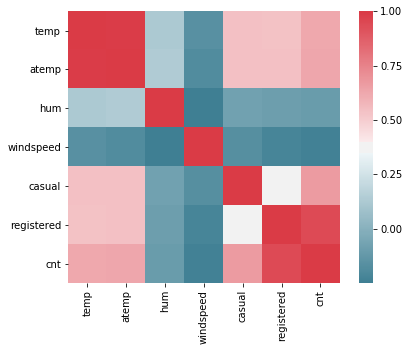

In [19]:
#Correlation Plot
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = Data.loc[:,Con_Var].corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

#Conclusion
#"temp" & "atemp" are highly correlated and
#comparatively "temp" is less correlated with "cnt", so discarding "atemp"
#"casual" & "registered" summation results in "cnt", so as per the problem statement, its enough if we analyse "cnt" w.r.t other variables. Hence discarding "casual" & "registered"


In [20]:
#ANOVA Test
ANO_Test = ols('cnt ~ yr + season + mnth + week_in_month + day + weathersit', data = BikeRent).fit()
#Check summary of ANO_Test for a conclusion
ANO_Test.summary()

##Conclusion
#p-values of all variables are less than 0.05 (except for some splits of variables), hence all are considerable

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     132.9
Date:                Thu, 17 Jan 2019   Prob (F-statistic):          1.34e-238
Time:                        10:14:20   Log-Likelihood:                -5958.6
No. Observations:                 731   AIC:                         1.197e+04
Df Residuals:                     707   BIC:                         1.208e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            667.9900    240.709      2.775      0.006     195.401    1140.579
yr[T.1]             2135.2470     63.303     33.731      0.000    2010.963    2259.531
season[T.2]          915.6482    198.658      4.609      0.000     525.617    1305.679
season[T.3]         1163.7021    234.338      4.966      0.000     703.621    1623.784
season[T.4]         1821.9423    198.948      9.158      0.000    1431.343    2212.542
mnth[T.2]            390.7457    156.950      2.490      0.013      82.602     698.889
mnth[T.3]           1195.6748    168.889      7.080      0.000     864.091    1527.259
mnth[T.4]           1391.7454    251.801      5.527      0.000     897.379    1886.112
mnth[T.5]           2211.2575    250.947      8.812      0.000    1718.568    2703.947
mnth[T.6]           2401.4428    244.333      9.829      0.000    1921.738    2881.148
mnth[T.7]           2049.1485    280.221      7.313      0.000    1498.983    2599.314
mnth[T.8]           2183.9036    280.077      7.798      0.000    1634.021    2733.786
mnth[T.9]           2329.1179    256.652      9.075      0.000    1825.226    2833.010
mnth[T.10]          1365.4918    251.342      5.433      0.000     872.026    1858.958
mnth[T.11]           231.8442    252.375      0.919      0.359    -263.651     727.339
mnth[T.12]           160.2701    199.933      0.802      0.423    -232.264     552.804
week_in_month[T.1]   257.4319    130.163      1.978      0.048       1.880     512.983
week_in_month[T.2]    81.8022    130.120      0.629      0.530    -173.666     337.271
week_in_month[T.3]   257.7941    129.893      1.985      0.048       2.773     512.815
week_in_month[T.4]   431.4368    130.228      3.313      0.001     175.758     687.116
day[T.1]             419.4198    197.165      2.127      0.034      32.321     806.518
day[T.2]             625.1879    192.403      3.249      0.001     247.438    1002.938
weathersit[T.2]     -728.0767     69.004    -10.551      0.000    -863.554    -592.600
weathersit[T.3]    -2576.1987    193.902    -13.286      0.000   -2956.891   -2195.506
==============================================================================
Omnibus:                       98.764   Durbin-Watson:                   1.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              373.749
Skew:                          -0.584   Prob(JB):                     6.94e-82
Kurtosis:                       6.303   Cond. No.                         33.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
#Dimesion Reduction

BikeData = BikeRent.drop(['dteday', 'holiday', 'weekday', 'workingday', 'atemp', 'casual', 'registered'],1)

In [22]:
#Rearrange Columns

BikeData = BikeData[['yr', 'season', 'mnth', 'week_in_month', 'day', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt']]

In [23]:
##Feature Scaling 
#Normalisation of "cnt" ##All other continuous variables are already normalised
BikeData['cnt'] = (BikeData['cnt'] - BikeData['cnt'].min())/((BikeData['cnt'].max()) - BikeData['cnt'].min())

In [24]:
BikeData.head(10)

,yr,season,mnth,week_in_month,day,weathersit,temp,hum,windspeed,cnt
0,0,1,1,1,1,2,0.344167,0.805833,0.160446,0.110792
1,0,1,1,1,1,2,0.363478,0.696087,0.248539,0.089623
2,0,1,1,1,2,1,0.196364,0.437273,0.248309,0.152669
3,0,1,1,1,2,1,0.200000,0.590435,0.160296,0.177174
4,0,1,1,1,2,1,0.226957,0.436957,0.186900,0.181546
5,0,1,1,1,2,1,0.204348,0.518261,0.089565,0.182237
6,0,1,1,1,2,2,0.196522,0.498696,0.168726,0.171192
7,0,1,1,3,1,2,0.165000,0.535833,0.266804,0.107800
8,0,1,1,3,1,1,0.138333,0.434167,0.361950,0.092039
9,0,1,1,3,2,1,0.150833,0.482917,0.223267,0.149448


# (Regression) Model Development

In [25]:
#Divide data into train and test
train, test = train_test_split(BikeData, test_size = 0.2)

In [26]:
train.shape

(584, 10)

In [27]:
test.shape

(147, 10)

In [28]:
#Define MAPE
def mape(predict, true):
    mape = np.mean(np.abs((true-predict)/true))
    return mape

In [29]:
#Define RMSE
def rmse(predict, true):
    rmse = np.sqrt(((true - predict) ** 2).mean())
    return rmse

In [30]:
#Decision Tree Regression
DT_Reg = DecisionTreeRegressor(max_depth = 2).fit(train.iloc[:,0:9], train.iloc[:,9])

#Apply DT model on test data for predictions
Predictions_DT = DT_Reg.predict(test.iloc[:,0:9])

In [ ]:
DT_Reg

In [31]:
#Error Metrics - Decision Tree Regression

#Mean Absolute error in Decision Tree Regressor
print("mae_DT = ", mean_absolute_error(test.iloc[:,9],Predictions_DT))

#Mean Squared error in Decision Tree Regressor
print("mse_DT = ", mean_squared_error(test.iloc[:,9],Predictions_DT))

#Mean Absolute Percentage Error in Decision Tree Regressor
print("mape_DT = ", mape(test.iloc[:,9],Predictions_DT))

#Mean Squared Error in Decision Tree Regressor
print("rmse_DT = ", rmse(test.iloc[:,9],Predictions_DT))

mae_DT =  0.0942449293346048
mse_DT =  0.014268134227209897
mape_DT =  0.21387388453879622
rmse_DT =  0.11944929563295834


In [32]:
#Random Forest Regression
RF_Reg = RandomForestRegressor(max_depth = 2, n_estimators = 100).fit(train.iloc[:,0:9], train.iloc[:,9])

#Apply RF model on test data for predictions
Predictions_RF = RF_Reg.predict(test.iloc[:,0:9])

In [ ]:
RF_Reg

In [33]:
#Error Metrics - Random Forest Regression

#Mean Absolute error in Decision Tree Regressor
print("mae_RF = ", mean_absolute_error(test.iloc[:,9],Predictions_RF))

#Mean Squared error in Decision Tree Regressor
print("mse_RF = ", mean_squared_error(test.iloc[:,9],Predictions_RF))

#Mean Absolute Percentage Error in Decision Tree Regressor
print("mape_RF = ", mape(test.iloc[:,9],Predictions_RF))

#Mean Squared Error in Decision Tree Regressor
print("rmse_RF = ", rmse(test.iloc[:,9],Predictions_RF))

mae_RF =  0.08341095633185726
mse_RF =  0.011349430293904861
mape_RF =  0.17915757605034446
rmse_RF =  0.10653370496657318


In [40]:
#Linear Regression 
Lin_Reg = sm.OLS(train.iloc[:,9], train.iloc[:,0:9].astype(float)).fit()

#Apply LR model on test data for predictions
Predictions_LR = Lin_Reg.predict(test.iloc[:,0:9])

In [ ]:
Lin_Reg

In [41]:
#Error Metrics - Linear Regression

#Mean Absolute error in Decision Tree Regressor
print("mae_LR = ", mean_absolute_error(test.iloc[:,9],Predictions_LR))

#Mean Squared error in Decision Tree Regressor
print("mse_LR = ", mean_squared_error(test.iloc[:,9],Predictions_LR))

#Mean Absolute Percentage Error in Decision Tree Regressor
print("mape_LR = ", mape(test.iloc[:,9],Predictions_LR))

#Mean Squared Error in Decision Tree Regressor
print("rmse_LR = ", rmse(test.iloc[:,9],Predictions_LR))

mae_LR =  0.07825860660653779
mse_LR =  0.010275695561316349
mape_LR =  0.18111119795570987
rmse_LR =  0.10136910555645812


In [36]:
#KNN Regression
KNN_Reg = KNeighborsRegressor(n_neighbors = 7).fit(train.iloc[:,0:9], train.iloc[:,9])

#Apply KNN model on test data for predictions
Predictions_KNN = KNN_Reg.predict(test.iloc[:,0:9])

In [ ]:
KNN_Reg

In [37]:
#Error Metrics - KNN Regression

#Mean Absolute error in Decision Tree Regressor
print("mae_KNN = ", mean_absolute_error(test.iloc[:,9],Predictions_KNN))

#Mean Squared error in Decision Tree Regressor
print("mse_KNN = ", mean_squared_error(test.iloc[:,9],Predictions_KNN))

#Mean Absolute Percentage Error in Decision Tree Regressor
print("mape_KNN = ", mape(test.iloc[:,9],Predictions_KNN))

#Mean Squared Error in Decision Tree Regressor
print("rmse_KNN = ", rmse(test.iloc[:,9],Predictions_KNN))

mae_KNN =  0.07920814108300607
mse_KNN =  0.010120591695129987
mape_KNN =  0.16184634796764039
rmse_KNN =  0.10060115155966151


# Conclusion

In [ ]:
##Random Forest model with number of trees = 100, KNN model with 7 neighbors
#and Multiple-Linear Regression model
#has given the best results w.r.t every error metric.
#So for the given data set and problem statement,
#we can select any one of these three.